# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [4]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149

stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)
stteff_tess = ufloat(3353, 157)

# TESS data

In [5]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

In [6]:
lk.search_targetpixelfile('TIC 22233480')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
2,TESS Sector 52,2022,SPOC,120,22233480,0.0
3,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
4,TESS Sector 53,2022,SPOC,120,22233480,0.0
5,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0


In [7]:
#!python ~/tpfplotter/tpfplotter.py 22233480 --maglim 6 --sector 53

In [8]:
lk.search_lightcurve('TIC 22233480')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
2,TESS Sector 40,2021,QLP,600,22233480,0.0
3,TESS Sector 52,2022,SPOC,120,22233480,0.0
4,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
5,TESS Sector 52,2022,QLP,600,22233480,0.0
6,TESS Sector 53,2022,SPOC,120,22233480,0.0
7,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0
8,TESS Sector 53,2022,QLP,600,22233480,0.0


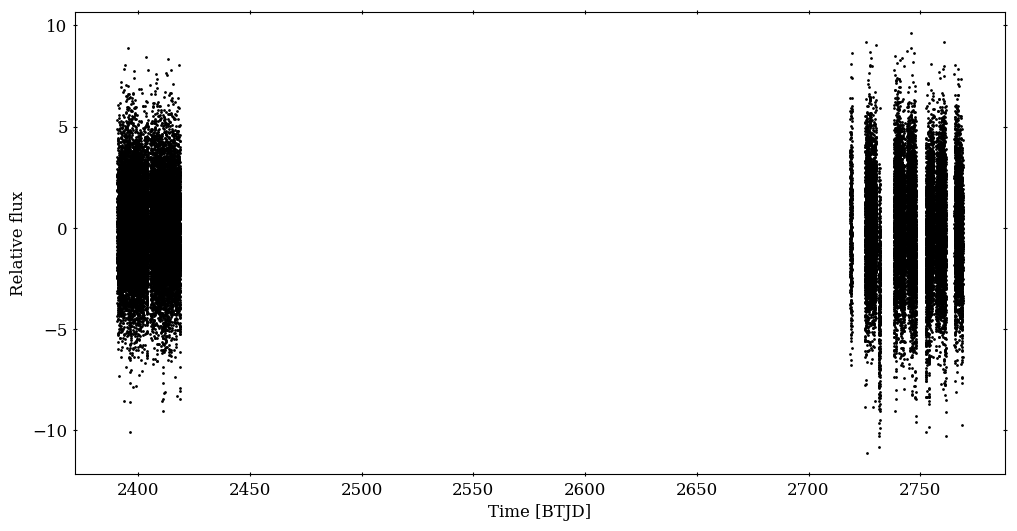

In [9]:
sr = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120)
sr.table["dataURL"] = sr.table["dataURI"]  # workaround MAST issue
lcc = sr.download_all(flux_column="pdcsap_flux")
lc = lcc.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lcc[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='k', markersize=1)
#plt.xlim(2380, 2430)
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
plt.show()

In [10]:
# lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=53).download_all(flux_column="pdcsap_flux").plot()

### BLS

In [11]:
from astropy.timeseries import BoxLeastSquares
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 10000)) #1 y 15 
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100))

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:', bls_period)
print('bls t0:', bls_t0)
print('bls depth:', bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration*24)

bls period: 7.446010472543779
bls t0: -183.3988671463317
bls depth: 3.9738512073534187
ref_time: 2579.818961811437
epoch: 2396.4200946651054
bls duration: 1.7680000000000005


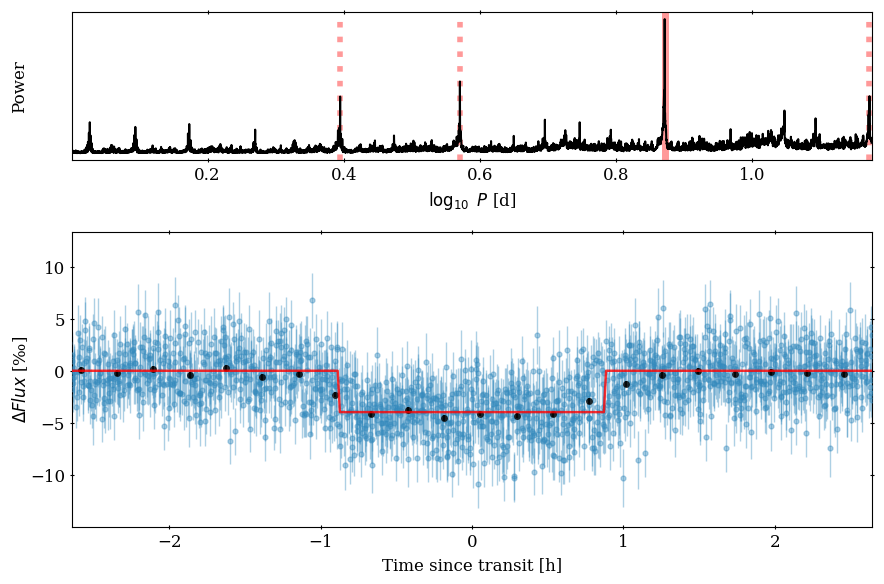

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

ax2.plot(x_fold_*24, y_, ".", alpha=0.4, ms=7, color='#348ABD', zorder=100)
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", color='#348ABD', elinewidth=1, alpha=0.4, capsize=0)

#Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8, zorder=200)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")

# plot the BLS model
x_bin = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x_bin + bls_t0, bls_period, bls_duration, bls_t0)
ax2.plot(x_bin*24, f, lw=1.75, color='red', zorder=1000, alpha=0.8)
plt.tight_layout()


Text(0, 0.5, 'relative flux [ppt]')

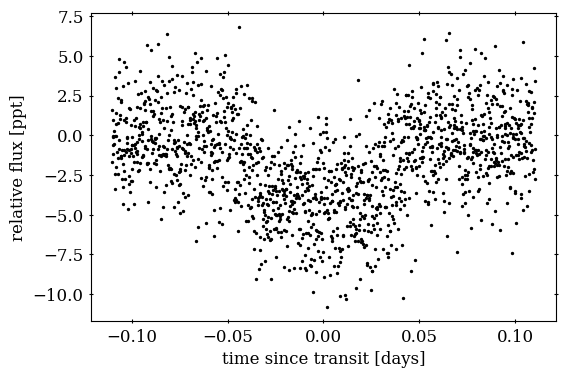

In [13]:
transit_mask = bls.transit_mask(x_, bls_period, bls_duration*3, bls_t0)

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)

plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
#plt.xlim(-0.12,0.12)

In [14]:
len(x_fold)

1531

In [15]:
lstess = LombScargle(x_[~transit_mask], y_[~transit_mask], yerr_[~transit_mask])
probabilities = [0.01]
ftess, ptess = lstess.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=50)
fapstess = lstess.false_alarm_level(probabilities)
best_frequency = ftess[np.argmax(ptess)]

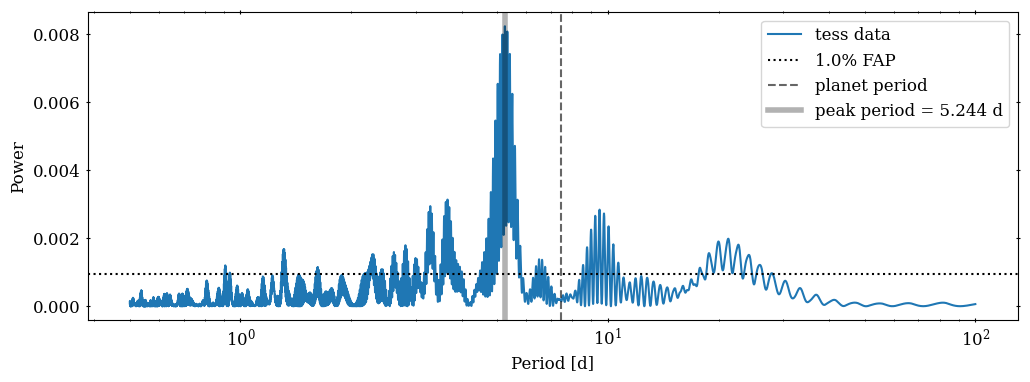

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(1/ftess, ptess, label='tess data')
ax.axhline(fapstess, ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
ax.set_xscale('log')
ax.set_ylabel('Power')
ax.set_xlabel('Period [d]')
ax.axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='planet period')
ax.axvline(1/best_frequency, color="k", lw=4, alpha=0.3, label='peak period = {} d'.format(round(1/best_frequency, 3)))
ax.legend(loc='upper right')
plt.savefig('tess_periodogram.png', dpi=300, bbox_inches='tight')
plt.show()

# RV reading

In [17]:
lbl_gl699 = pd.read_table('./lbl_toi4438_gl699/lbl_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699 = pd.read_table('./lbl_toi4438_gl699/lbl2_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl514 = pd.read_table('./lbl_toi4438_gl514/lbl2_TOI4438_GL514.rdb', sep=None, engine='python', header=0)
lbl_gl514 = pd.read_table('./lbl_toi4438_gl514/lbl_TOI4438_GL514.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI4438_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)
lbl2_gl699_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI4438_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)
lbl2_gl514_new = pd.read_table('./new_montreal/lbl2_TOI4438_GL514_bervzp.rdb', sep=None, engine='python', header=0)
lbl2_gl699_new = pd.read_table('./new_montreal/lbl2_TOI4438_GL699_bervzp.rdb', sep=None, engine='python', header=0)

names = ['lbl2_gl699_new']
#names = ['lbl2_gl699']

star_name = 'toi4438'

In [18]:
print(len(lbl2_gl699_car_vtot10), len(lbl2_gl699))

51 51


In [19]:
#datasets = list([lbl_gl699])
datasets = list([lbl2_gl699_new])
#datasets = list([lbl2_gl699])
#datasets = list([lbl2_gl514])
#datasets = list([lbl_gl514])

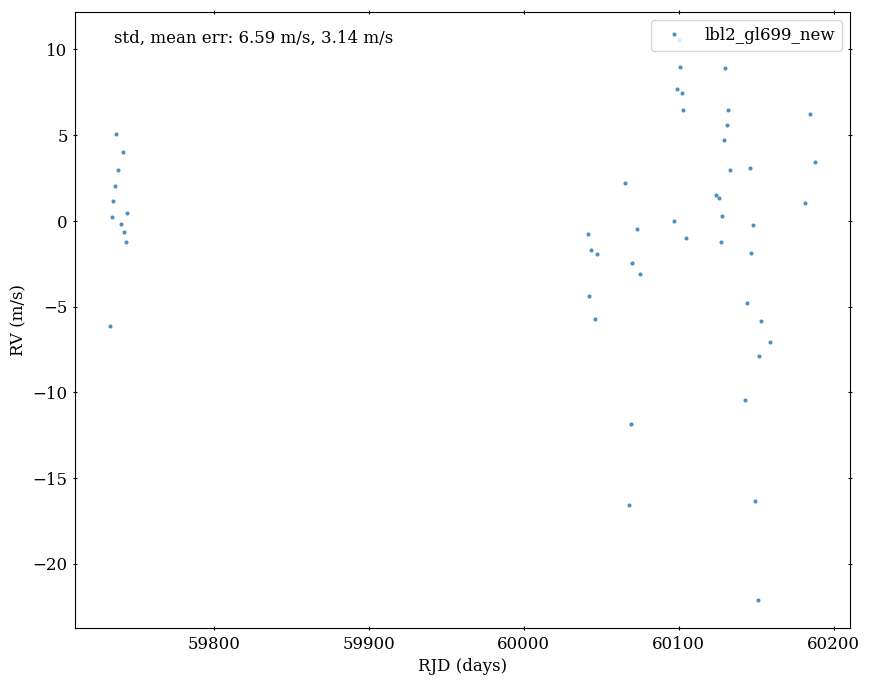

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [21]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(51, 185)


In [22]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[1]


In [23]:
# print the 5 points with largest errorbar
for k, data in enumerate(datasets):
    print(data['svrad'].sort_values(ascending=False).head(10))

34    7.542942
49    4.948958
13    4.189355
38    3.758465
44    3.489217
17    3.437304
39    3.360688
40    3.332460
22    3.218980
10    3.209682
Name: svrad, dtype: float64


In [24]:
# print the 5 points with largest errorbar
for k, data in enumerate(datasets):
    print(data['vrad'].sort_values(ascending=False).head(10))

24   -35075.888049
25   -35077.483127
34   -35077.496973
23   -35078.727142
26   -35078.944900
36   -35079.940526
27   -35079.965188
48   -35080.178374
35   -35080.865179
4    -35081.381565
Name: vrad, dtype: float64


In [25]:
datasets[0] = datasets[0].drop([34])

In [26]:
# substract the systemic velocity and use ref_time as the zero point
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())
    i['rjd'] = i['rjd'].apply(lambda x: x - 57000 - ref_time)


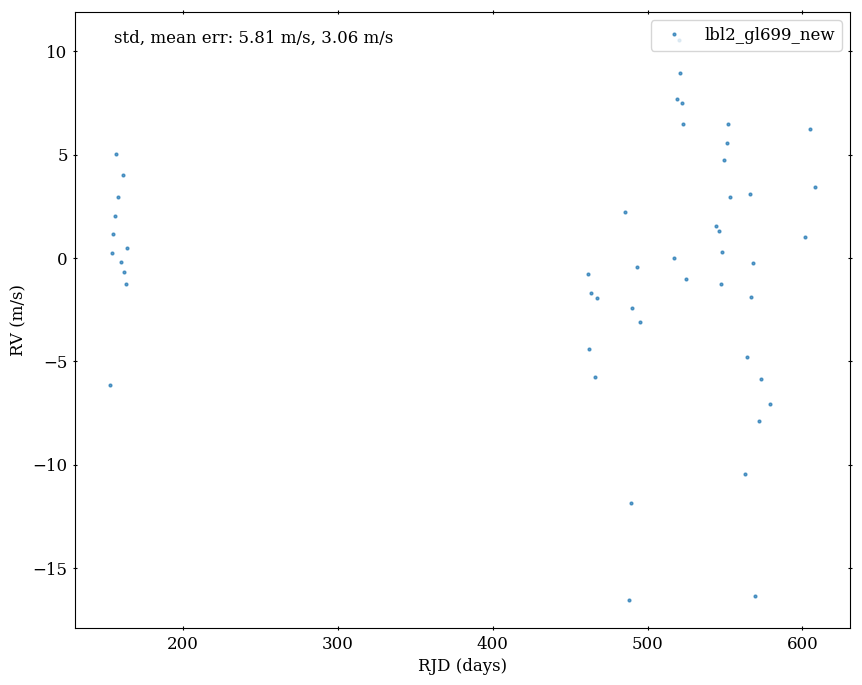

In [27]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

In [28]:
len(datasets[0])

49

# GLS

In [29]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    ls[k+1] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    #ls[k+1] = LombScargle(data['rjd'], data['d2v'], data['sd2v'])
    #ls[k+2] = LombScargle(data['rjd'], data['d2v'], data['sd2v'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    frequency[k+1], power[k+1] = ls[k+1].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    #frequency[k+2], power[k+2] = ls[k+2].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    faps[k] = ls[k].false_alarm_level(probabilities)
    faps[k+1] = ls[k+1].false_alarm_level(probabilities)
    #faps[k+2] = ls[k+2].false_alarm_level(probabilities)

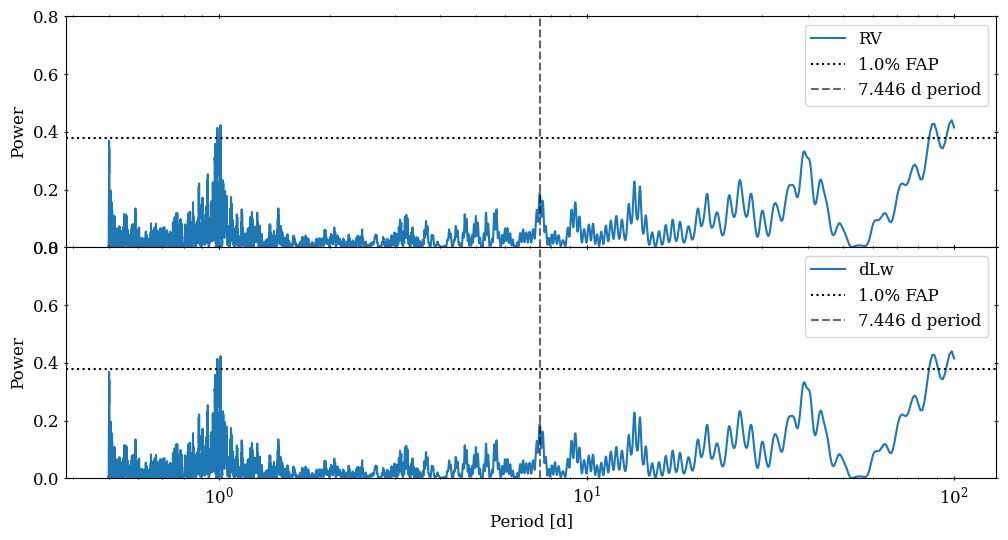

In [30]:
# activity indicator dLW (differential line width) is 'd2v', in reality 'd2v' is dLW x 8ln2 so dLW multiplied by a constant
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line
fig, axes = plt.subplots(len(datasets)+1, 1, sharex=False, figsize=(12, 3*(len(datasets)+1)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

names2 = ['RV', 'dLw']
for i in range(len(datasets)+1):
    axes[i].plot(1/frequency[i], power[i], label=names2[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 0.8)

plt.savefig('rv_gls.png', dpi=300, facecolor='w', bbox_inches='tight')

# Joint fit 

In [31]:
maxrv = dict()
Kest = dict()
x_ref = dict()

for k, data in enumerate(datasets):
    maxrv[k] = np.std(data['vrad'])*3
    Kest[k] = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'])
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    print('Kest:', Kest[k])

Kest: [3.35082015]


In [32]:
bls_depth*1e-3

0.003973851207353419

In [33]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t_rv = dict()
phase_lc = np.linspace(-0.15, 0.15, 500)

for k, data in enumerate(datasets):
    t_rv[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        logP = pm.Normal("logP", mu=np.log(bls_period), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)

        # logK = pm.Normal("logK", mu=np.log(Kest[k].item()), sd=2.0, testval=np.log(Kest[k].item()))
        # K = pm.Deterministic("K", tt.exp(logK))
        K = pm.Uniform("K", lower=0, upper=10)

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit         
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth*1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * rstar)
        b = xo.ImpactParameter('b', ror)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar,
                                        b=b)

        # derive mass, semimajor axis, and equilibrium temperature, and denisty
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
        density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))
        teq = pm.Deterministic('teq', stteff_tess.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))

        # The light curve model
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=1)

        def lc_model(mean, star, r_pl, texp, t):
            return pm.Deterministic("lc_model_", tt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean)
        
        lc_model_ = lc_model(mean, star, r_pl, texp, x)
        # The likelihood for the light curve
        err_lc = tt.sqrt(yerr**2 + tt.exp(2*logs)) 
        transit_obs = pm.Normal("lc_obs", mu=lc_model_, sd=err_lc, observed=y) 

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred", tt.sum(star.get_light_curve(orbit=orbit, r=r_pl, t=t0+phase_lc, texp=texp)*1e3, axis=-1))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t_rv[k], name="_pred")

        # Finally add in the RV observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [34]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [logs, u_star, mean, b, log_ror, trend, log_sigma_rv, K, t0, logP, rstar, mstar]


message: Desired error not necessarily achieved due to precision loss.
logp: -3876.4825536779335 -> -3640.2152390152223
optimizing logp for variables: [t0, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.2152390152223 -> -3640.2152390152223
optimizing logp for variables: [logs, u_star, mean, b, log_ror, trend, log_sigma_rv, K, t0, logP, rstar, mstar]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.2152390152223 -> -3640.2152390152223


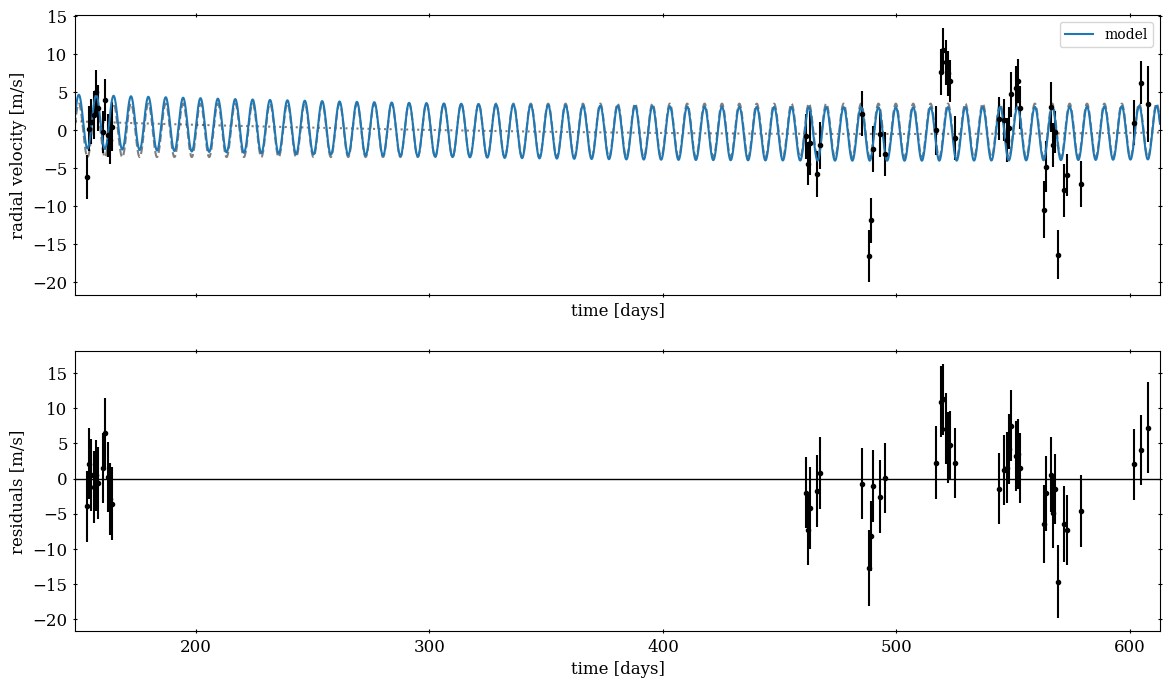

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax = axes[0]
ax.errorbar(datasets[0]['rjd'], datasets[0]['vrad'], yerr=datasets[0]['svrad'], fmt=".k")
ax.plot(t_rv[0], map_soln['vrad_pred'], "--k", alpha=0.5)
ax.plot(t_rv[0], map_soln['bkg_pred'], ":k", alpha=0.5)
ax.plot(t_rv[0], map_soln['rv_model_pred'], label="model")
ax.legend(fontsize=10)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
    
ax = axes[1]
err = np.sqrt(datasets[0]['svrad']**2 + np.exp(2 * map_soln["log_sigma_rv"]))
ax.errorbar(datasets[0]['rjd'], datasets[0]['vrad'] - map_soln["rv_model"], yerr=err, fmt=".k")
ax.axhline(0, color="k", lw=1)
ax.set_ylabel("residuals [m/s]")
ax.set_xlim(t_rv[0].min(), t_rv[0].max())
ax.set_xlabel("time [days]")
plt.show()

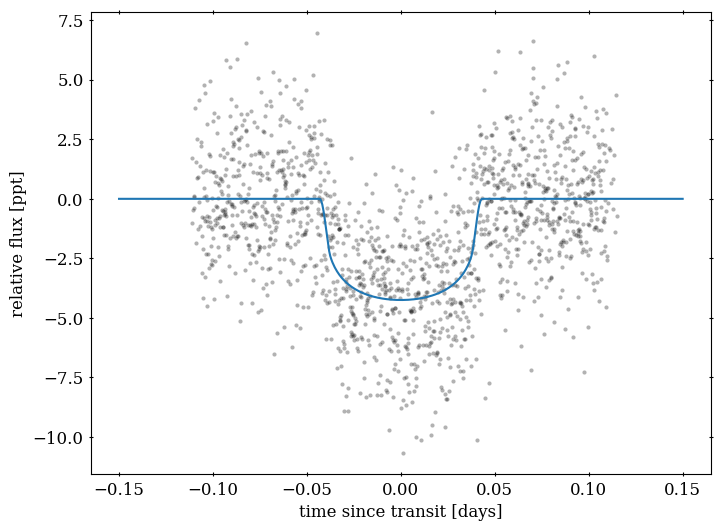

In [36]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)
period = map_soln["P"]
folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
ax.plot(folded,(y  - map_soln["mean"]),".k",alpha=0.3,mec="none",)
ax.plot(phase_lc, map_soln['lc_pred'], label=names[0])
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux [ppt]")
plt.show()

# Sampling

In [37]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            start=map_soln,
            cores=2,
            chains=1,
            target_accept=0.95,
            return_inferencedata=True,
            #random_seed=[203771098, 203775000],
            #init="adapt_full",
        )

Sequential sampling (1 chains in 1 job)
NUTS: [logs, u_star, mean, b, log_ror, trend, log_sigma_rv, K, t0, logP, rstar, mstar]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 182 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [38]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'm_pl', 'r_pl', 'a', 'density_pl', 'teq', 'b', 
                    'u_star', 'logs', 'log_sigma_rv', 'trend', 'mstar', 'rstar'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


1844.8239158421052 1272.3229266315789 nan


In [39]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-1.834035e+02,9.460000e-04,-1.834063e+02,-1.834005e+02,1.900000e-05,1.400000e-05,2467.135184,1453.859109,NaN,-1.834035e+02,9.460000e-04
logP,2.007694e+00,3.000000e-06,2.007687e+00,2.007702e+00,0.000000e+00,0.000000e+00,2077.635335,1599.555857,NaN,2.007695e+00,3.000000e-06
P,7.446130e+00,1.900000e-05,7.446075e+00,7.446189e+00,0.000000e+00,0.000000e+00,2077.635335,1599.555857,NaN,7.446131e+00,1.900000e-05
K,3.401670e+00,1.053340e+00,5.371190e-01,6.447000e+00,2.379300e-02,1.682700e-02,1910.302080,968.569803,NaN,3.380395e+00,1.053077e+00
m_pl,3.080070e+25,9.531486e+24,4.806972e+24,5.955180e+25,2.158845e+23,1.526762e+23,1883.035873,1031.667891,NaN,3.072934e+25,9.529103e+24
r_pl,2.259200e-02,6.630000e-04,2.059100e-02,2.465800e-02,1.600000e-05,1.100000e-05,1814.031887,1526.148483,NaN,2.255600e-02,6.630000e-04
a,5.259600e-02,9.020000e-04,4.986200e-02,5.514600e-02,2.100000e-05,1.500000e-05,1929.292267,1637.653132,NaN,5.259100e-02,9.010000e-04
density_pl,1.905123e+00,6.183080e-01,2.656800e-01,3.774941e+00,1.364800e-02,9.652000e-03,1879.906220,1055.721341,NaN,1.882196e+00,6.181540e-01
teq,4.384862e+02,5.135492e+00,4.222856e+02,4.548647e+02,1.319620e-01,9.332900e-02,1543.639624,1497.900100,NaN,4.386100e+02,5.134208e+00
b,1.298050e-01,8.805100e-02,4.600000e-05,3.979750e-01,2.751000e-03,1.946000e-03,888.537234,794.109424,NaN,1.144390e-01,8.802900e-02


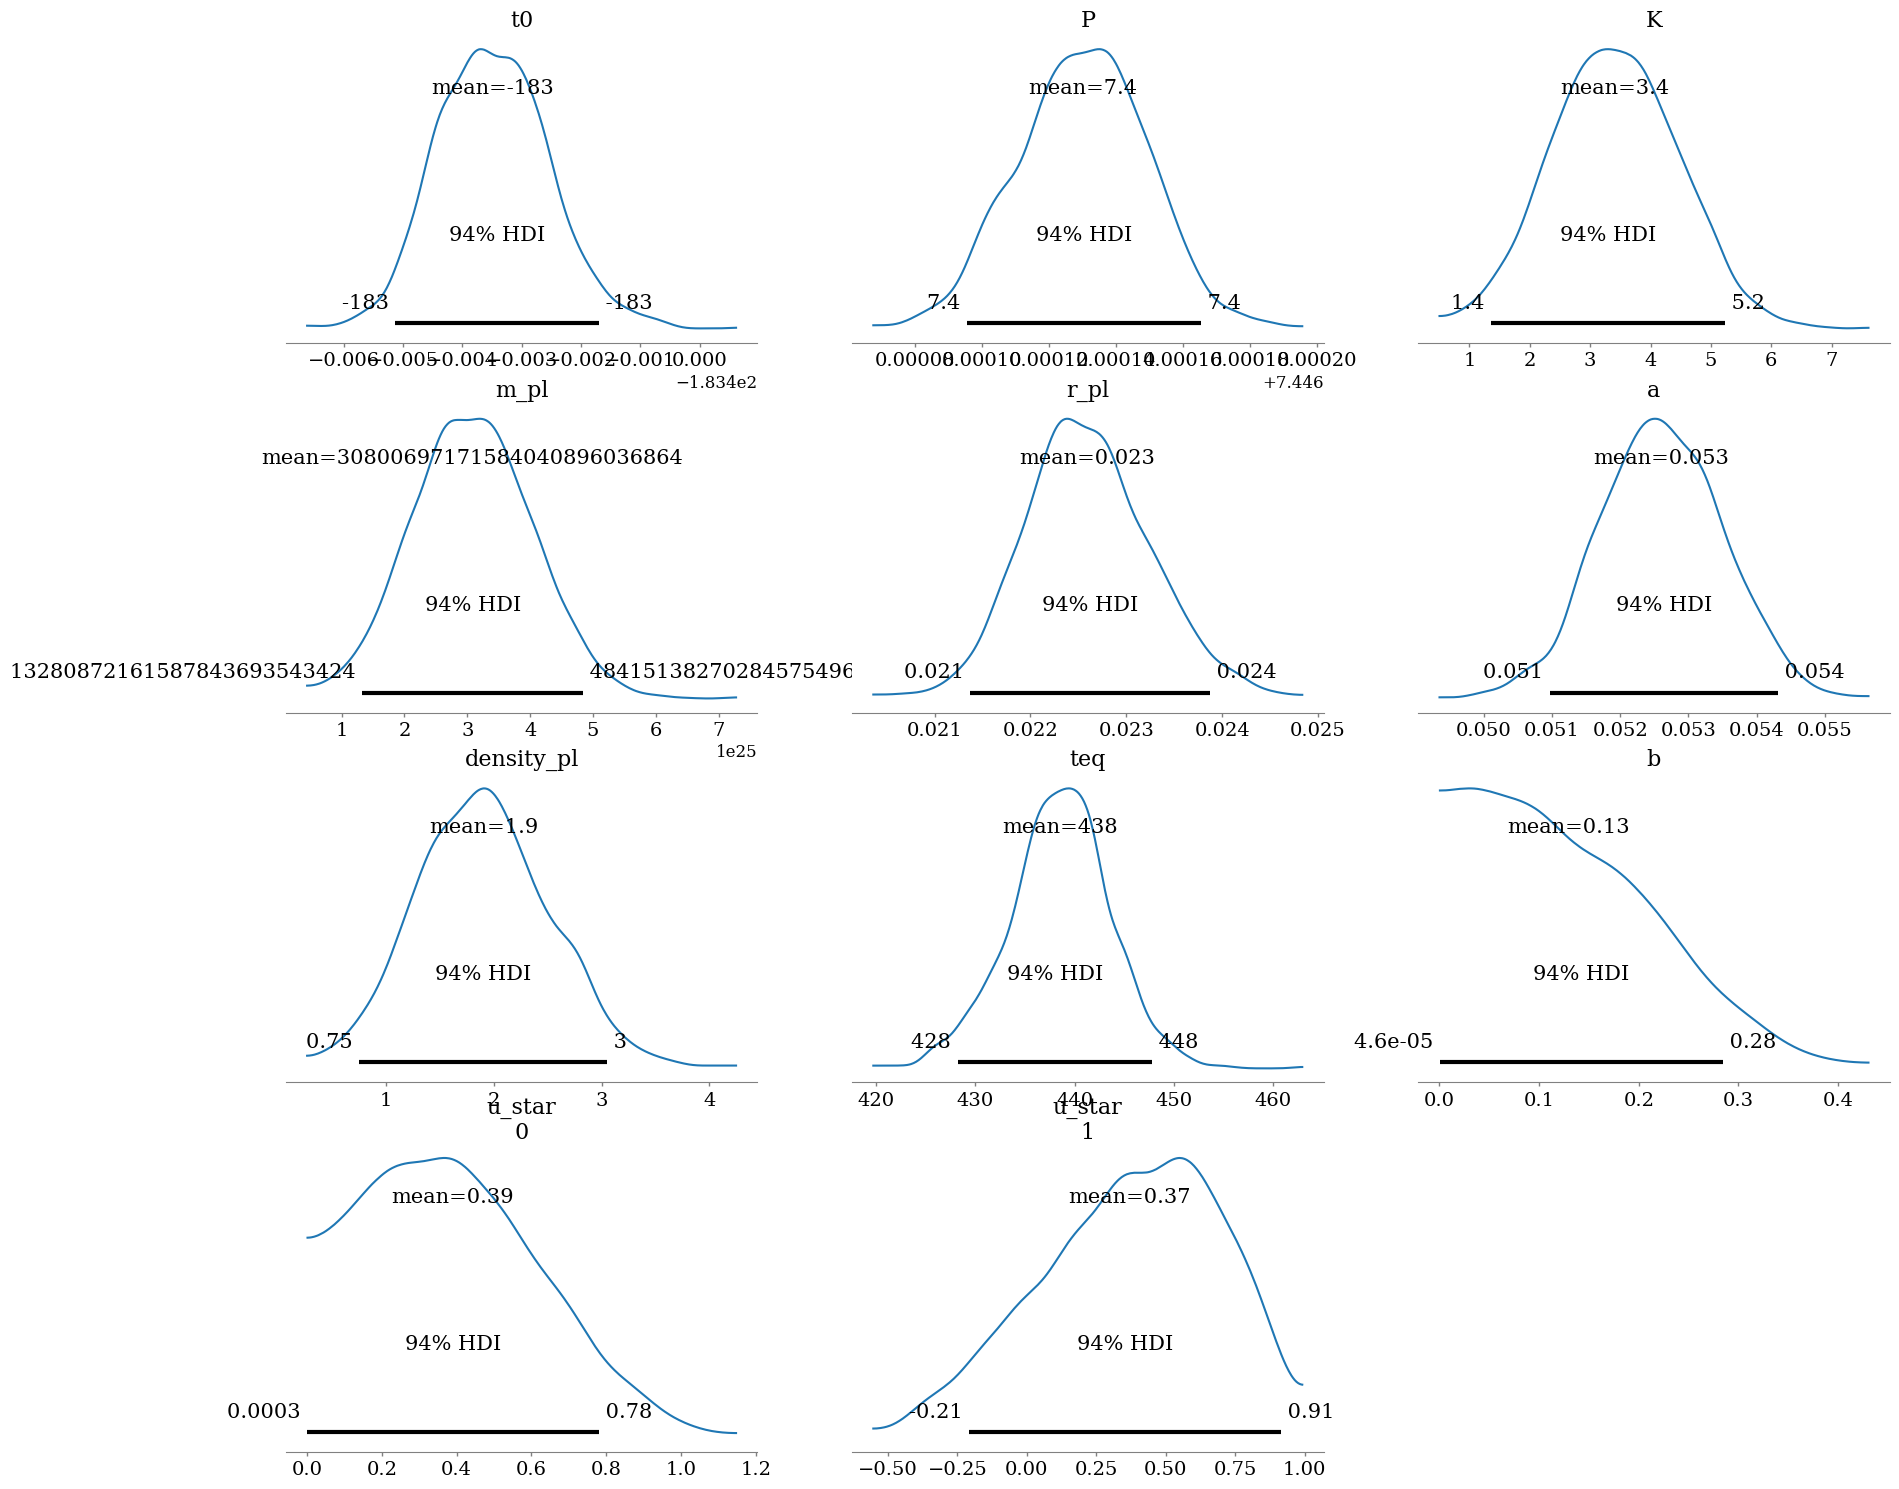

In [40]:
az.plot_posterior(traces[0], var_names=['t0', 'P', 'K', 'm_pl', 'r_pl', 'a', 'density_pl', 'teq', 'b', 'u_star'])
plt.show()

## Results

In [41]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
R_pl = dict()
Density = dict()
T_eq = dict()
b_ = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
ror = dict()
depth = dict()
rv_jitter_ = dict()
lc_jitter = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
lc_preds = dict()
lc_preds_ = dict()
lc_model = dict()
mean_lc = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = ufloat((traces[i].posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, 
                     (traces[i].posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
    K[i] = ufloat(traces[i].posterior["K"].median().item(), traces[i].posterior["K"].std().item())
    period[i] = ufloat(traces[i].posterior['P'].median().item(),traces[i].posterior['P'].std().item())
    t_0[i] = ufloat(traces[i].posterior['t0'].median().item(), traces[i].posterior['t0'].std().item())
    R_pl[i] = ufloat((traces[i].posterior["r_pl"].median().item()*u.R_sun).to(u.R_earth).value,
                    (traces[i].posterior["r_pl"].std().item()*u.R_sun).to(u.R_earth).value)
    Density[i] = ufloat(traces[i].posterior["density_pl"].median().item(), traces[i].posterior["density_pl"].std().item())
    T_eq[i] = ufloat(traces[i].posterior["teq"].median().item(), traces[i].posterior["teq"].std().item())
    b_[i] = ufloat(traces[i].posterior["b"].median().item(), traces[i].posterior["b"].std().item())
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())
    smaxis[i] = ufloat(traces[i].posterior['a'].median().item(), traces[i].posterior['a'].std().item())
    ror[i] = ufloat(traces[i].posterior['ror'].median().item(), traces[i].posterior['ror'].std().item())
    depth[i] = ror[i]**2
    logsigma_rv = ufloat(traces[i].posterior["log_sigma_rv"].median().item(), traces[i].posterior["log_sigma_rv"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    logs = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    lc_jitter[i] = np.e**logs
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))
    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1)
    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)

    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))
    mean_lc[i] = np.median(flat_samps[i]['mean'].values, axis=-1)
    lc_preds[i] = np.median(flat_samps[i]['lc_pred'].values, axis=-1)
    lc_preds_[i] = np.percentile(traces[i].posterior["lc_pred"].values,[16, 50, 84], axis=(0, 1))
    lc_model[i] = np.median(flat_samps[i]['lc_model_'].values, axis=-1)
    
    print('REDUCTION: ', names[i])
    print('---------------------------------------------')
    print("Mp = {m:.3f} Mearth".format(m=mass[i]))
    print('K = {k:.3f} m/s'.format(k=K[i]))
    print("P = {p:.6f} days".format(p=period[i]))
    print("Radius = {r:.3f} Rearth".format(r=R_pl[i]))
    print("Density = {d:.3f} g/cm3".format(d=Density[i]))
    print("T_eq = {t:.3f} K".format(t=T_eq[i]))
    print("b = {b:.3f}".format(b=b_[i]))
    print("Epoch = {e:.5f}".format(e=t_0[i]))
    print('a = {a:.4f} AU'.format(a=smaxis[i]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print("LC jitter = ", lc_jitter[i])
    print("LC baseline = ", mean_lc[i])
    print("Transit depth = ", depth[i]*1e3) 
    print('---------------------------------------------')

REDUCTION:  lbl2_gl699_new
---------------------------------------------
Mp = 5.145+/-1.596 Mearth
K = 3.380+/-1.053 m/s
P = 7.446131+/-0.000019 days
Radius = 2.460+/-0.072 Rearth
Density = 1.882+/-0.618 g/cm3
T_eq = 438.610+/-5.134 K
b = 0.114+/-0.088
Epoch = -183.40353+/-0.00095
a = 0.0526+/-0.0009 AU
mstar = 0.350+/-0.018 Msun
rstar = 0.387+/-0.009 Rsun
RV jitter =  4.3+/-0.7
LC jitter =  0.43+/-0.19
LC baseline =  -0.160278453720323
Transit depth =  3.41+/-0.17
---------------------------------------------


## Plot results

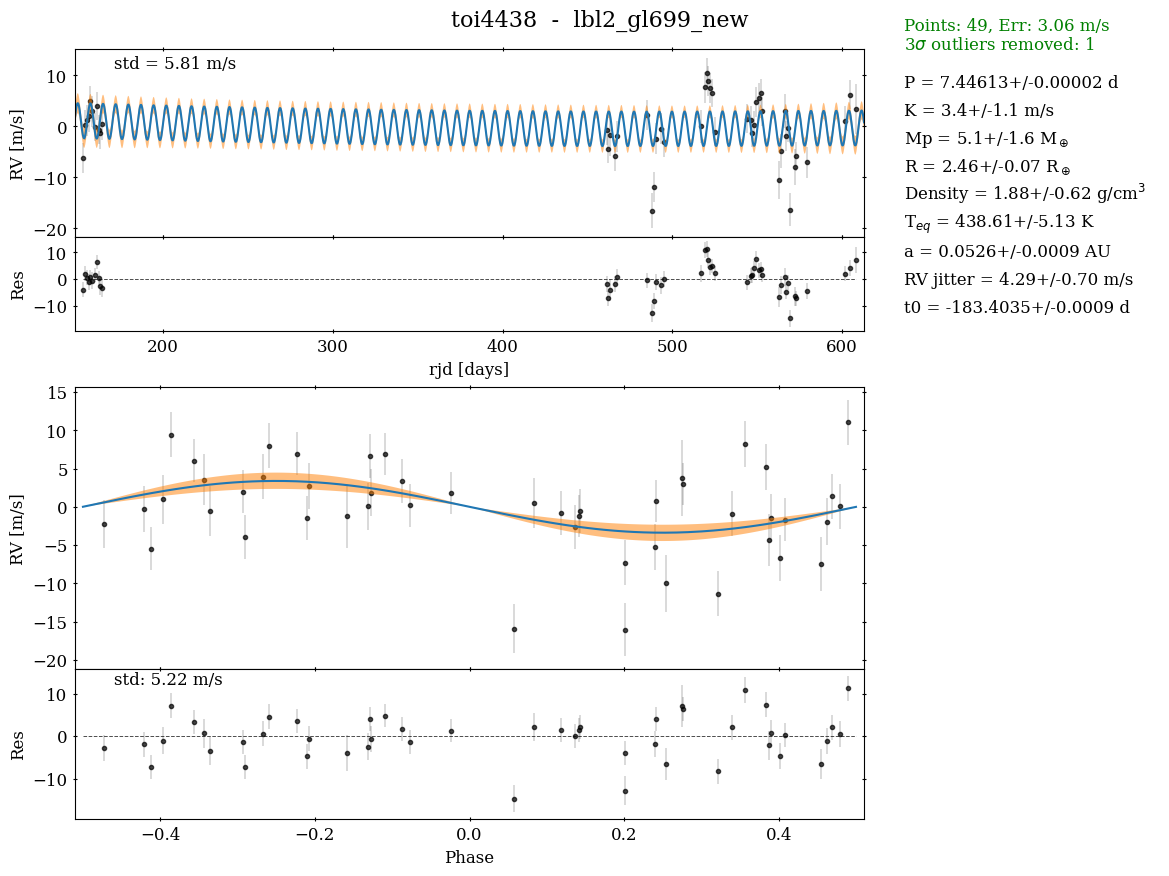

In [42]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(star_name+'  -  '+names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    # add radius, density, teq
    ax[0,1].text(-0.3, 0.35, 'R = {r:.2f} R$_\oplus$'.format(r=R_pl[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'Density = {d:.2f} g/cm$^3$'.format(d=Density[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 'T$_{{eq}}$ = {t:.2f} K'.format(t=T_eq[k]), fontsize=12)
    ax[1,1].text(-0.3, 0.8, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[1,1].text(-0.3, 0.5, 'RV jitter = {j:.2f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[1,1].text(-0.3, 0.2, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t_rv[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t_rv[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=data['svrad'], fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t_rv[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

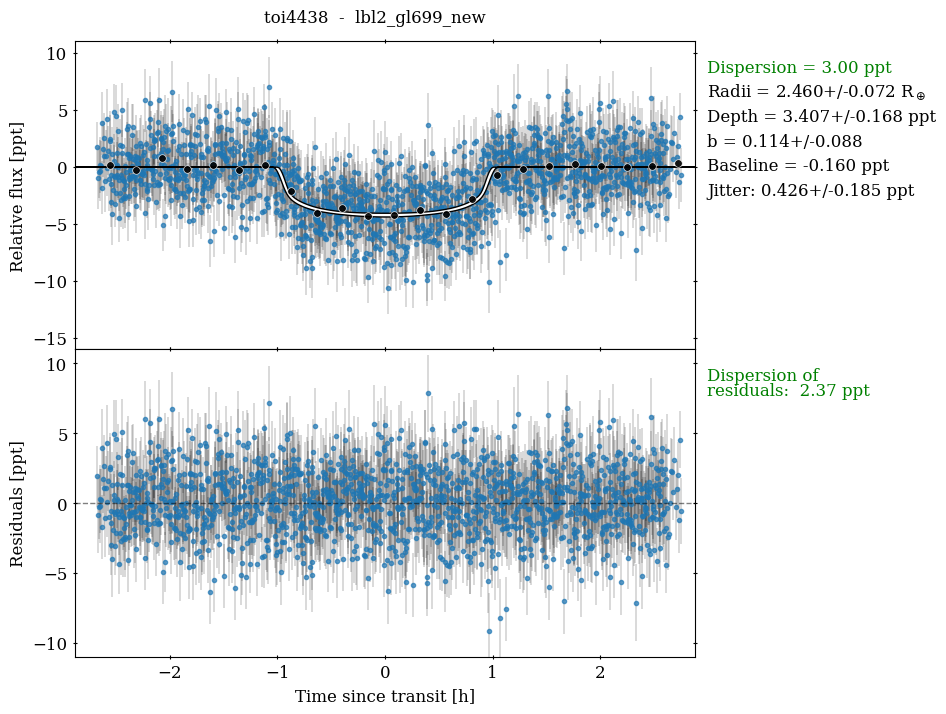

In [43]:
fig, axes = plt.subplots(2, sharex=True, figsize=(8, 8))
# title the entire plot
fig.suptitle(star_name+'  -  '+names[k], y=0.92, fontsize=12)
plt.subplots_adjust(hspace=0.0)
folded = (x - t_0[0].n + 0.5 * period[0].n) % period[0].n - 0.5 * period[0].n
axes[0].errorbar(folded*24, y - mean_lc[0], yerr=yerr, fmt=".", label='data', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
axes[0].set_ylabel("Relative flux [ppt]")
axes[0].set_xlabel("Time since transit [h]")
axes[0].set_xlim(-0.12*24, 0.12*24)
axes[0].set_ylim(-16,11)
# Overplot the phase binned light curve 
lcc = lk.LightCurve(time=folded, flux=y - mean_lc[0], flux_err=yerr)
lcc_binned = lcc.bin(time_bin_size=0.01, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
axes[0].scatter(lcc_binned['time'].value*24, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='w', linewidths=0.5, c='k', alpha=0.9, zorder=12)
# overplot the model
art = axes[0].fill_between(phase_lc*24, lc_preds_[0][0], lc_preds_[0][2], color="w", alpha=1, zorder=10)
art.set_edgecolor("k")

axes[0].text(1.02, 0.90, 'Dispersion = {o:.2f} ppt'.format(o=np.std(y)), fontsize=12, color='g', transform=axes[0].transAxes)
axes[0].text(1.02, 0.82, 'Radii = {r:.3f} R$_\oplus$'.format(r=R_pl[0]), fontsize=12, color='k', transform=axes[0].transAxes)
axes[0].text(1.02, 0.74, 'Depth = {d:.3f} ppt'.format(d=depth[0]*1e3), fontsize=12, color='k', transform=axes[0].transAxes)
axes[0].text(1.02, 0.66, 'b = {b:.3f}'.format(b=b_[0]), fontsize=12, color='k', transform=axes[0].transAxes)
axes[0].text(1.02, 0.58, 'Baseline = {p:.3f} ppt'.format(p=mean_lc[0]), fontsize=12, color='k', transform=axes[0].transAxes)
axes[0].text(1.02, 0.50, 'Jitter: {t:.3f} ppt'.format(t=lc_jitter[0]), fontsize=12, color='k', transform=axes[0].transAxes)

axes[1].errorbar(folded*24, y - mean_lc[0] - lc_model[0], yerr=yerr, fmt=".", label='data', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
axes[1].set_ylabel("Residuals [ppt]")
axes[1].set_xlabel("Time since transit [h]")
axes[1].set_xlim(-0.12*24, 0.12*24)
axes[1].set_ylim(-11,11)
axes[1].set_yticks([-10, -5, 0, 5, 10])
axes[1].axhline(0, ls="--", color="k", lw=1, alpha=0.5)
axes[1].text(1.02, 0.90, 'Dispersion of', fontsize=12, color='g', transform=axes[1].transAxes)
axes[1].text(1.02, 0.85, 'residuals:  {o:.2f} ppt'.format(o=np.std(y - mean_lc[0] - lc_model[0])), fontsize=12, color='g', transform=axes[1].transAxes)
plt.savefig('lc_fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()